In [107]:
import pandas as pd
import numpy as np
import yfinance as yf
from keras import Sequential, Input
from keras.src.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

In [108]:
# data = yf.download('BTC-USD', '2015-01-01', '2024-05-23', interval='1d')
# btcDF = pd.DataFrame(data)
btcDF = pd.read_csv('btc.csv', on_bad_lines='skip', engine='python')

In [109]:
# Добавление столбцов с датой и временем
# btcDF['Date'] = btcDF.index.date
# btcDF['Time'] = pd.to_datetime(btcDF.index).time
btcDF['Timestamp'] = pd.to_datetime(btcDF['Timestamp'])

btcDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57285 entries, 0 to 57284
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Timestamp          57285 non-null  datetime64[ns]
 1   Open               57285 non-null  float64       
 2   High               57285 non-null  float64       
 3   Low                57285 non-null  float64       
 4   Close              57285 non-null  float64       
 5   Volume (BTC)       57285 non-null  float64       
 6   Volume (Currency)  57285 non-null  float64       
 7   Weighted Price     57281 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 3.5 MB


In [110]:
btcDF.head()

,Timestamp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
0,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,202366.138393,4289.143931
1,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,100304.823567,4316.986709
2,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,31282.312670,4326.922502
3,2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,19241.058300,4330.402888
4,2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,4239.503586,4358.010978


In [111]:
# numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume (BTC)', 'Volume (Currency)', 'Weighted Price']
btcDF[numeric_cols] = btcDF[numeric_cols].fillna(btcDF[numeric_cols].mean())
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(btcDF[numeric_cols])
# scaled_data = scaler.fit_transform(btcDF)

In [112]:
# Функция для создания набора данных
def create_dataset(data, n_steps=1):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps, :])
        y.append(data[i + n_steps, 3])  # Используем 'Close' (индекс 3) как целевой признак
    return np.array(X), np.array(y)

In [113]:
# Создание набора данных
n_steps = 3  # Количество временных шагов
X, y = create_dataset(scaled_data, n_steps)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))  # Преобразование для LSTM

In [114]:
# Разделение данных на обучающую и тестовую выборки
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

In [115]:
# Определение и компиляция модели LSTM
model = Sequential()
model.add(Input(shape=(n_steps, X.shape[2])))  # Указываем форму входных данных через Input
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [116]:
# Обучение модели
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/50
534/534 - 3s - 6ms/step - loss: 2.0848e-04 - val_loss: 0.0027
Epoch 2/50
534/534 - 2s - 4ms/step - loss: 2.1377e-04 - val_loss: 0.0017
Epoch 3/50
534/534 - 2s - 4ms/step - loss: 1.0791e-04 - val_loss: 5.1043e-04
Epoch 4/50
534/534 - 2s - 4ms/step - loss: 7.7581e-05 - val_loss: 2.7077e-04
Epoch 5/50
534/534 - 2s - 3ms/step - loss: 7.8135e-05 - val_loss: 2.4026e-04
Epoch 6/50
534/534 - 2s - 4ms/step - loss: 7.8932e-05 - val_loss: 2.3742e-04
Epoch 7/50
534/534 - 2s - 4ms/step - loss: 7.8091e-05 - val_loss: 2.2612e-04
Epoch 8/50
534/534 - 2s - 4ms/step - loss: 7.5984e-05 - val_loss: 2.0337e-04
Epoch 9/50
534/534 - 2s - 3ms/step - loss: 7.3319e-05 - val_loss: 1.7249e-04
Epoch 10/50
534/534 - 2s - 4ms/step - loss: 6.9441e-05 - val_loss: 1.4155e-04
Epoch 11/50
534/534 - 2s - 4ms/step - loss: 6.6824e-05 - val_loss: 1.1403e-04
Epoch 12/50
534/534 - 2s - 4ms/step - loss: 6.3472e-05 - val_loss: 9.0972e-05
Epoch 13/50
534/534 - 2s - 4ms/step - loss: 6.0195e-05 - val_loss: 7.0571e-05
Epo

In [117]:
# Сохранение модели
model.save('lstm_bitcoin_model.keras')

In [118]:
# Прогнозирование
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1] * test_X.shape[2]))


591/591 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [119]:
# Инверсия масштабирования
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)  # -6, т.к. у нас 7 числовых столбцов всего
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 3]  # Используем 'Close' (индекс 3) после инверсии

In [120]:

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 3]  # Используем 'Close' (индекс 3) после инверсии


In [121]:
# Расчет и вывод ошибок
mse = mean_squared_error(inv_y, inv_yhat)
rmse = sqrt(mse)
print(f'Test MSE: {mse:.3f}')
print(f'Test RMSE: {rmse:.3f}')

Test MSE: 0.000
Test RMSE: 0.000


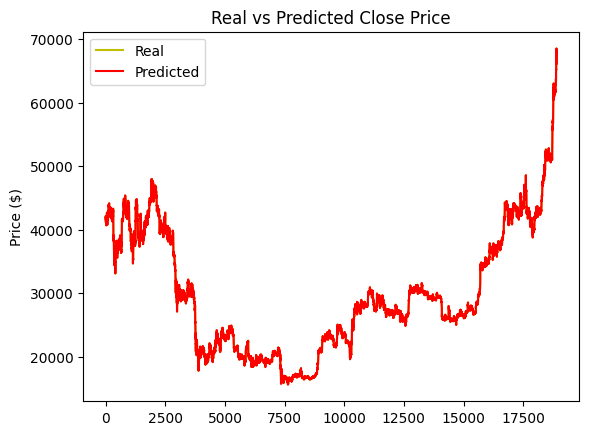

In [122]:
# Визуализация результатов
plt.title('Real vs Predicted Close Price')
plt.ylabel('Price ($)')
plt.plot(inv_y, label='Real', color='y')
plt.plot(inv_yhat, label='Predicted', color='r')
plt.legend()
plt.show()

In [123]:
from keras.src.saving import load_model

# Загрузка модели
model = load_model('lstm_bitcoin_model.keras')

def prepare_data_for_prediction(df, n_steps, scaler):
    data = df[['Open', 'High', 'Low', 'Close', 'Volume (BTC)', 'Volume (Currency)', 'Weighted Price']].values
    scaled_data = scaler.transform(data)
    
    def create_input(data, n_steps=1):
        X = []
        for i in range(len(data) - n_steps + 1):
            a = data[i:i + n_steps, :]
            X.append(a)
        return np.array(X)

    X = create_input(scaled_data, n_steps)
    X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))
    
    return X

def predict_price_on_date(date_str):
    # Преобразуем дату в формат datetime
    target_date = pd.to_datetime(date_str)
    
    # Получаем последние n_steps дней до текущей даты
    end_idx = len(btcDF) - 1
    start_idx = end_idx - n_steps + 1
    
    if start_idx < 0:
        raise ValueError(f"Недостаточно данных для прогноза на дату {date_str}.")
    
    input_data = btcDF.iloc[start_idx:end_idx + 1]
    X_input = prepare_data_for_prediction(input_data, n_steps, scaler)
    
    # Предсказание
    yhat = model.predict(X_input[-1].reshape(1, n_steps, X_input.shape[2]))
    
    # Создание массива с нулями для инверсии масштабирования
    zeros = np.zeros((yhat.shape[0], X_input.shape[2] - 1))
    yhat_combined = np.concatenate((zeros, yhat), axis=1)
    
    # Инверсия масштабирования только для предсказанных значений
    inv_yhat = scaler.inverse_transform(yhat_combined)
    predicted_price = inv_yhat[:, 3]  # Используем 'Close' (индекс 3) после инверсии
    
    return predicted_price[0]

# Пример использования функции
date_str = '2024-05-23'
predicted_price = predict_price_on_date(date_str)
print(f'Предсказанная цена биткоина на дату {date_str}: ${predicted_price:.2f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Предсказанная цена биткоина на дату 2024-05-23: $2919.00


/home/nikonych/PycharmProjects/crypto_prediction/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
